In [22]:
import os
import numpy as np
from sklearn.model_selection import train_test_split


from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPool1D, Flatten, concatenate, Dense, \
    LSTM, Bidirectional, Activation, MaxPooling1D, Add, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, \
    TimeDistributed, Permute, multiply, Lambda, add, Masking, BatchNormalization, Softmax, Reshape, ReLU, \
    ZeroPadding1D, subtract
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
from keras import backend as K, initializers, regularizers, constraints


# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from tensorflow.keras.layers import Layer, InputSpec
import numpy as np

from statistics import mode

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
%matplotlib inline
import tensorflow as tf

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list
import tensorflow_hub as hub



import re
import nltk
from nltk.corpus import stopwords
import ast
# neural
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

#Metrics
from sklearn.metrics import balanced_accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
# from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier


# Read CSv file

In [23]:
restaurant_df = pd.read_csv("processed_ASTE-Data-V2/16res_train_original.csv")

In [24]:
restaurant_df

,text,aspect,opinion,sentiment
0,Judging from previous posts this used to be a ...,['place'],['good'],['NEG']
1,"We , there were four of us , arrived at noon -...",['staff'],['rude'],['NEG']
2,The food was lousy - too sweet or too salty an...,"['food', 'food', 'food', 'portions']","['lousy', 'too sweet', 'too salty', 'tiny']","['NEG', 'NEG', 'NEG', 'NEG']"
3,Avoid this place !,['place'],['Avoid'],['NEG']
4,"I have eaten at Saul , many times , the food i...",['food'],['good'],['POS']
...,...,...,...,...
852,bad staff,['staff'],['bad'],['NEG']
853,I generally like this place .,['place'],['like'],['POS']
854,The food is good .,['food'],['good'],['POS']
855,The design of the space is good .,['space'],['good'],['POS']


In [25]:

df = restaurant_df.drop('opinion', axis=1)


In [26]:

df

,text,aspect,sentiment
0,Judging from previous posts this used to be a ...,['place'],['NEG']
1,"We , there were four of us , arrived at noon -...",['staff'],['NEG']
2,The food was lousy - too sweet or too salty an...,"['food', 'food', 'food', 'portions']","['NEG', 'NEG', 'NEG', 'NEG']"
3,Avoid this place !,['place'],['NEG']
4,"I have eaten at Saul , many times , the food i...",['food'],['POS']
...,...,...,...
852,bad staff,['staff'],['NEG']
853,I generally like this place .,['place'],['POS']
854,The food is good .,['food'],['POS']
855,The design of the space is good .,['space'],['POS']


In [27]:
# Changing multiple column names at once
df.rename(columns={'text': 'Sentence', 'aspect': 'Aspect_Category' , 'sentiment': 'polarity'}, inplace=True)


## Convert to lists

In [28]:

# Function to convert the string representation of lists to actual lists
def convert_to_list(row):
    return ast.literal_eval(row)

# Apply the converter function to the 'Aspect_Category' column
df['Aspect_Category'] = df['Aspect_Category'].apply(convert_to_list)
df['polarity'] = df['polarity'].apply(convert_to_list)


In [29]:
print(type(df['Aspect_Category'][1] ))

<class 'list'>


# Get unique aspects

In [30]:
# Function to read the CSV data and create a set of unique aspects
def get_unique_aspects(csv_data):
    unique_aspects_set = set()

    for aspect_list in csv_data:
        unique_aspects_set.update(aspect_list)

    return list(unique_aspects_set)

# Get the list of unique aspects
unique_aspects_list = get_unique_aspects(df['Aspect_Category'])
print("Unique Aspects List:", unique_aspects_list)
print(len(unique_aspects_list))

Unique Aspects List: ['maitre-D', 'trattoria', 'setting', 'bread', 'crab salad', 'martinis', 'scheme of mirrors', 'house champagne', 'beverage selections', "Patsy 's Pizza", 'arugula and goat cheese', 'calamari', 'wine choices', 'spaghetti with Scallops and Shrimp', 'foie gras terrine with figs', 'Ingredients', 'modern Japanese brasserie', 'cuisine', 'Thin Crust Pizzas', 'Atmosphere', 'looks', 'Greg', 'indian place', 'bar', 'spicy tuna roll', 'atmoshpere', 'vent', 'Food', 'Thai style Fried Sea Bass', 'mozzarella en Carozza', 'bathroom', 'pumkin tortelini', 'Casa La Femme', 'place', 'four course prix fix menu', 'Jekyll and Hyde', 'Jeckll and Hydes', 'asparagus , truffle oil , parmesan bruschetta', 'duck confit', 'room', 'atomosphere', 'wings with chimmichuri', 'portions', 'santa fe chopped salad', 'salmon dish', 'somosas', 'eggplant', 'Korean fair', 'Vanison', 'French Onion soup', 'bottle of wine', 'The Four Seasons restaurant', 'rock shrimp tempura', 'sangria', 'seabass', 'Pastis', 'cr

# Create empty list of one-hot with values 3 

In [31]:
df['hot_encoded'] = pd.NaT
aspects_terget_data = np.full((len(unique_aspects_list)), 3)
print(aspects_terget_data.shape)

df['hot_encoded'] = df['hot_encoded'].astype('object')
for i in np.arange(len(df)):
    df.at[i, 'hot_encoded'] =  aspects_terget_data

(528,)


In [32]:
df

,Sentence,Aspect_Category,polarity,hot_encoded
0,Judging from previous posts this used to be a ...,[place],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
1,"We , there were four of us , arrived at noon -...",[staff],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
2,The food was lousy - too sweet or too salty an...,"[food, food, food, portions]","[NEG, NEG, NEG, NEG]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
3,Avoid this place !,[place],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,"I have eaten at Saul , many times , the food i...",[food],[POS],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
...,...,...,...,...
852,bad staff,[staff],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
853,I generally like this place .,[place],[POS],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
854,The food is good .,[food],[POS],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
855,The design of the space is good .,[space],[POS],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."


In [33]:

from wordcloud import WordCloud
wordcloud2 = WordCloud().generate(' '.join(df['Sentence'])),

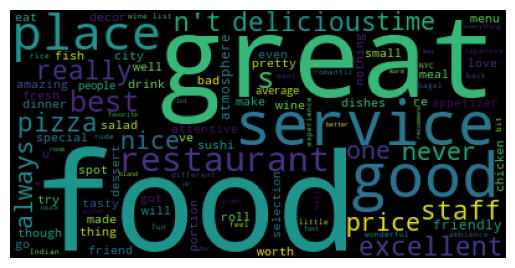

In [34]:
text3 = ' '.join(df['Sentence'])
wordcloud2 = WordCloud().generate(text3)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [35]:
df.head(5)

,Sentence,Aspect_Category,polarity,hot_encoded
0,Judging from previous posts this used to be a ...,[place],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
1,"We , there were four of us , arrived at noon -...",[staff],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
2,The food was lousy - too sweet or too salty an...,"[food, food, food, portions]","[NEG, NEG, NEG, NEG]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
3,Avoid this place !,[place],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,"I have eaten at Saul , many times , the food i...",[food],[POS],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."


In [36]:

for i in range(len(df)) :
    for aspect in unique_aspects_list:
        if aspect in df.Aspect_Category[i]:
            if df.polarity[i][df.Aspect_Category[i].index(aspect)] == 'POS' :
                # Create a copy of the list in the target row
                updated_list = df.at[i, 'hot_encoded'].copy()
                # Update the value in the copy
                updated_list[unique_aspects_list.index(aspect)] = 1
                # Assign the modified list back to the DataFrame
                df.at[i, 'hot_encoded'] = updated_list
            if df.polarity[i][df.Aspect_Category[i].index(aspect)] == 'NEG' :
                # Create a copy of the list in the target row
                updated_list = df.at[i, 'hot_encoded'].copy()
                # Update the value in the copy
                updated_list[unique_aspects_list.index(aspect)] = 0
                # Assign the modified list back to the DataFrame
                df.at[i, 'hot_encoded'] = updated_list
            if df.polarity[i][df.Aspect_Category[i].index(aspect)] == 'NEU' :
                # Create a copy of the list in the target row
                updated_list = df.at[i, 'hot_encoded'].copy()
                # Update the value in the copy
                updated_list[unique_aspects_list.index(aspect)] = 2
                # Assign the modified list back to the DataFrame
                df.at[i, 'hot_encoded'] = updated_list

In [43]:
unique_aspects_list.index('portions')


42

In [47]:
df['hot_encoded'][4][268]

1

In [42]:
df.head()

,Sentence,Aspect_Category,polarity,hot_encoded
0,Judging from previous posts this used to be a ...,[place],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
1,"We , there were four of us , arrived at noon -...",[staff],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
2,The food was lousy - too sweet or too salty an...,"[food, food, food, portions]","[NEG, NEG, NEG, NEG]","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
3,Avoid this place !,[place],[NEG],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,"I have eaten at Saul , many times , the food i...",[food],[POS],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
